In [2]:
import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent.parent)+'/lund-university-code')
sys.path.append(str(Path.cwd().parent.parent)+'/lund-university-code/TimeSeriesAnalysis')
sys.path.append(str(Path.cwd().parent.parent)+'/lund-university-code/TimeSeriesAnalysis/')

In [3]:
import pandas as pd
import TimeSeriesAnalysis.tsa_lth.analysis as analysis
import TimeSeriesAnalysis.tsa_lth.modelling as modelling
import TimeSeriesAnalysis.tsa_lth.tests as tests
from TimeSeriesAnalysis.tsa_lth.tools import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
import copy
import pylab

In [4]:
def getARMA(data, A=0, C=0):
    A_free=A
    C_free=C
    model = modelling.PEM(data, A=A, C=C)
    if isinstance(A, int):
        A_free = [1]*(A+1)
    if isinstance(C, int):
        C_free = [1]*(C+1)
    model.set_free_params(A_free=A_free, C_free=C_free)
    model_fitted = model.fit(method='LS', bh=False)
    model_fitted.summary()
    return model_fitted

def checkNormal(data, remove=False, title=None):
    if remove:
        data = data[remove:]
    tests.check_if_normal(data)
    stats.probplot(data, dist="norm", plot=pylab)
    if title:
        plt.title(title)
    pylab.show()
    
    
def analyzeARMA(x, A=0, C=0, noLags=50, titleStr=None, return_val=False, normal_test=True):
    model = getARMA(x, A=A, C=C)
    if isinstance(A, int): len_A = A
    else: len_A = len(A)
    if isinstance(C, int): len_C = C
    else: len_C = len(C)
    remove=max(len_A, len_C)
    res = model.resid
    acf_est, pacf_est = analysis.plotACFnPACF(res,noLags=noLags,titleStr=titleStr, return_val=True)
    tests.whiteness_test(res)
    if normal_test:
        checkNormal(acf_est, remove=remove, title='ACF')
        checkNormal(pacf_est, remove=remove, title='PACF')
    if return_val:
        return model, acf_est, pacf_est

# Import data

In [5]:
ElGeneina_mat = analysis.mat2np('./data/ElGeneina.mat')[0]
Kassala_mat = analysis.mat2np('./data/Kassala.mat')[0]

In [6]:
ElGeneina = pd.DataFrame()
col_names = ['nvdi', 'nvdi_t', 'rain', 'rain_t', 'rain_org', 'rain_org_t']
for i in range(len(ElGeneina_mat)):
    ElGeneina = pd.concat([ElGeneina, pd.DataFrame(ElGeneina_mat[i]).astype(float).round(6)], axis=1, ignore_index=True)
ElGeneina.columns = col_names
    
Kassala = pd.DataFrame()
for i in range(len(Kassala_mat)):
    Kassala = pd.concat([Kassala, pd.DataFrame(Kassala_mat[i]).astype(float).round(6)], axis=1, ignore_index=True)
Kassala.columns = col_names
Kassala.head(10)

,nvdi,nvdi_t,rain,rain_t,rain_org,rain_org_t
0,146.0,1982.013889,0.0,1960.013889,0.0,1960.041667
1,147.9,1982.041667,0.0,1960.041667,0.0,1960.125000
2,142.4,1982.069444,0.0,1960.069444,0.0,1960.208333
3,143.0,1982.097222,0.0,1960.097222,0.0,1960.291667
4,144.3,1982.125000,0.0,1960.125000,16.5,1960.375000
5,142.6,1982.152778,0.0,1960.152778,40.1,1960.458333
6,139.1,1982.180556,0.0,1960.180556,92.0,1960.541667
7,143.7,1982.208333,0.0,1960.208333,46.8,1960.625000
8,145.9,1982.236111,0.0,1960.236111,97.9,1960.708333
9,138.7,1982.263889,0.0,1960.263889,0.0,1960.791667


- High NDVI indicates presence of vegetation
- Low NDVI indicates barren ground, water, snow, ice, etc
- NDVI are stored as unsigned (8-bit) integers (i.e., between 0 and 255), and thus needs to be rescaled to [−1,1].
- NDVI is measured three times every month (day 1-10, 11-20, 21-end) 
- Rain_org is measured once every month
- Rain is linear interpolation of Rain_org to match NDVI
- Both NDVI and rain data had missing data points but were filled with Matlab misdata function.

# Recursive reconstruction of rain data

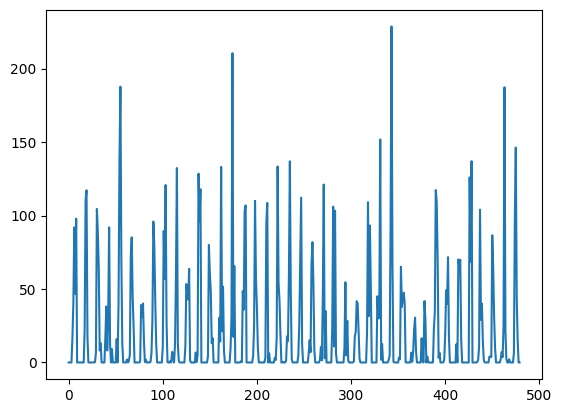

In [7]:
plt.plot(Kassala['rain_org'])
plt.show()

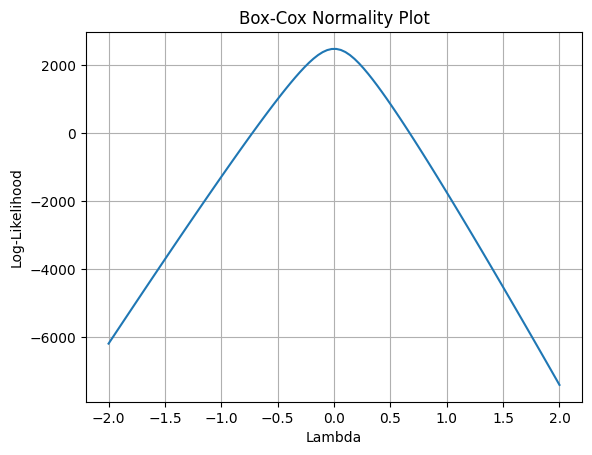

Max Lambda = 0.0019948143353221213.
ln(y) could be an appropriate transformation.


In [41]:
# Here we add a very small value to allow y to be strictly positive.
y = Kassala['rain_org'].values
y = y[:len(y)-960]
y = y + 1e-8
max_lambda = analysis.box_cox(y, 1)

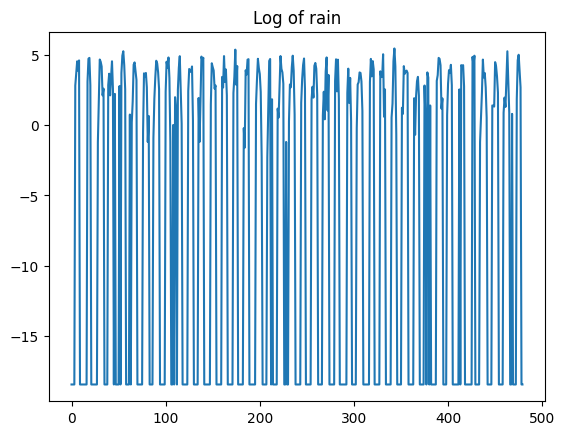

In [42]:
y = np.log(y)
plt.plot(y)
plt.title('Log of rain')
plt.show()

Discrete-time AR model: A(z)y(t) = e(t)

A(z) = 1.0 - 0.739(±0.03)·z⁻¹

Polynomial orders: nA = 1
Number of free coefficients: 1
Fit to estimation data (NRMSE): 17.69%
FPE : 73.905  MSE : 77.434
AIC : 3444.718   BIC : 3448.89



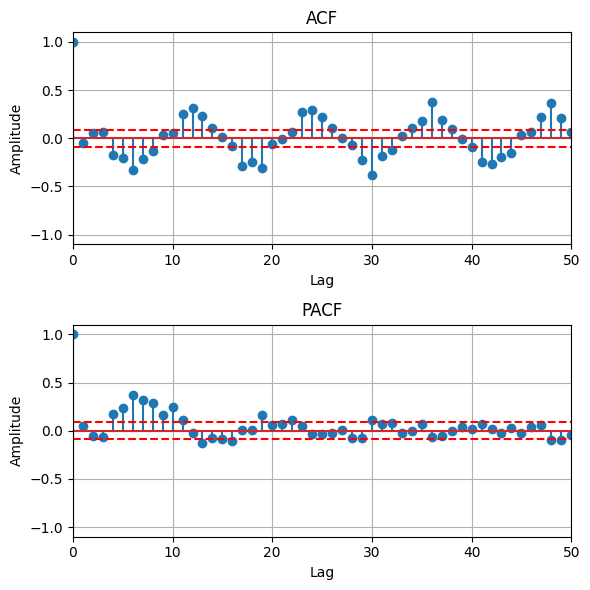

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 305.50 < 31.41)
  McLeod-Li test:        False (white if 126.23 < 31.41)
  Monti test:            False (white if 289.56 < 31.41)
  Sign change test:      False (white if 0.30 in [0.46,0.54])


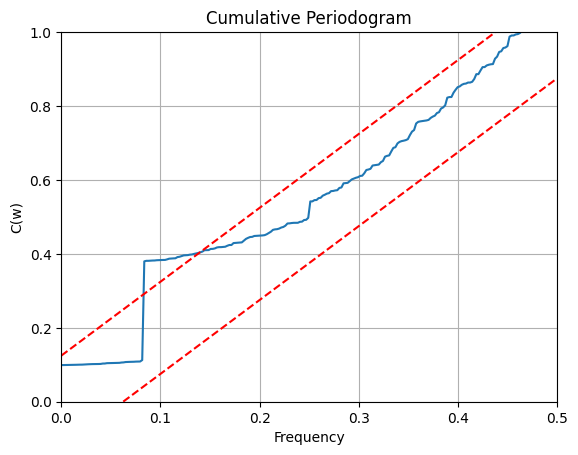

The D'Agostino-Pearson K2 test indicates that the data is NORMAL distributed.


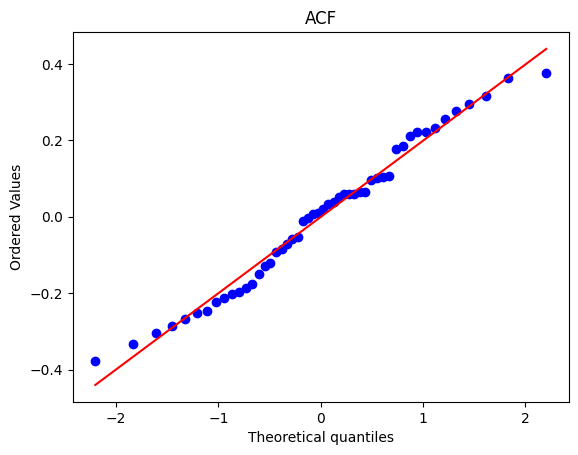

The D'Agostino-Pearson K2 test indicates that the data is NOT normal distributed.


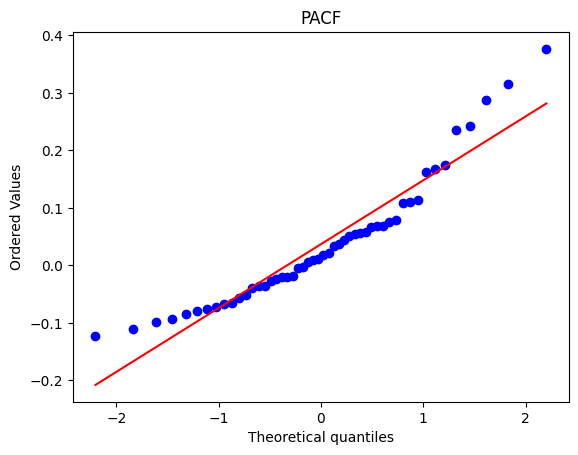

In [14]:
analyzeARMA(y, A=1)

In [10]:
# rain_df = pd.merge(Kassala['rain_t'], Kassala[['rain_org_t', 'rain_org']], how='outer', left_on='rain_t', right_on='rain_org_t').sort_values('rain_t').dropna(axis=0, how='all')
# rain_df['rain_org'] = rain_df['rain_org'].apply(lambda x: np.log(x+1e-8) if pd.notnull(x) else x)
# y = rain_df['rain_org'].values
# rain_df.tail(15)

,rain_t,rain_org_t,rain_org
1425,1999.597222,NaN,NaN
1426,1999.625000,1999.625000,4.985659
1427,1999.652778,NaN,NaN
1428,1999.680556,NaN,NaN
1429,1999.708333,1999.708333,3.768153
1430,1999.736111,NaN,NaN
1431,1999.763889,NaN,NaN
1432,1999.791667,1999.791667,2.681022
1433,1999.819444,NaN,NaN
1434,1999.847222,NaN,NaN


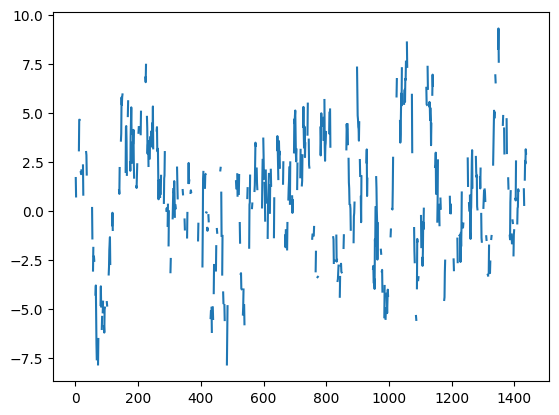

In [164]:
ytest = modelling.simulateARMA(AR=[1, -.95], size=1440)
# print(ycoef)
noVal = np.random.randint(low=0, high=1439, size=900)
ytest[noVal] = np.NaN
plt.plot(ytest)

In [43]:
y

array([-1.84206807e+01, -1.84206807e+01, -1.84206807e+01, -1.84206807e+01,
        2.80336038e+00,  3.69137633e+00,  4.52178858e+00,  3.84588320e+00,
        4.58394655e+00, -1.84206807e+01, -1.84206807e+01, -1.84206807e+01,
       -1.84206807e+01, -1.84206807e+01, -1.84206807e+01, -1.84206807e+01,
       -1.84206807e+01,  3.08190997e+00,  4.70682384e+00,  4.76388188e+00,
        2.82137889e+00, -1.84206807e+01, -1.84206807e+01, -1.84206807e+01,
       -1.84206807e+01, -1.84206807e+01, -1.84206807e+01, -1.84206807e+01,
       -1.20397277e+00,  1.90210753e+00,  4.64918707e+00,  4.48525989e+00,
        4.15418456e+00,  2.10413416e+00,  2.58021683e+00, -1.84206807e+01,
       -1.84206807e+01, -1.84206807e+01, -1.84206807e+01,  2.83321334e+00,
        3.64021428e+00,  2.10413416e+00,  3.40119738e+00,  4.52178858e+00,
        2.54160199e+00, -1.84206807e+01,  2.20827441e+00, -1.84206807e+01,
       -1.84206807e+01, -1.84206807e+01, -1.84206807e+01,  2.76631911e+00,
       -1.84206807e+01,  

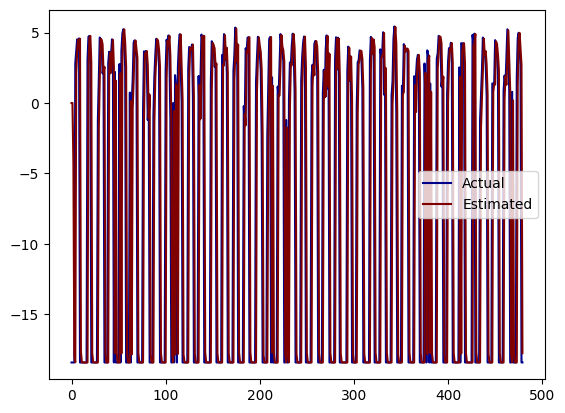

In [100]:
# Using log transformed data perform kalman gain to get the AR(1) coefficient
N = len(y)
a1 = 1    # Value of A1 parameter
A = a1 * np.eye(3) 
Re = 1000 * np.eye(3)   #   How fast changes of estimates are reflected. Since y_t = x_t + x_t-1 + x_t-2 exactly, we have to use big values of Re to see this.
Rw = 100    # How noisy the estimate will be

Rxx1 = 10 * np.eye(3)    # How confident we are with initial states
# xtt1 = np.array([y[0]/3]*3)    # Set initial states as the first value of rain/3
xtt1 = np.array([0]*3)    # Set initial states as 0

Xsave = np.zeros((3, N))
ehat = np.zeros(N)
yhat = np.zeros(N)
y1 = copy.deepcopy(y)

for t in range(1, N):
    # print(f'xtt1: {xtt1}')
    Ct = np.array([1,1,1]).reshape(1, -1)
    # print(f'Ct: {Ct}')
    Ryy = np.dot(np.dot(Ct, Rxx1), Ct.T) + Rw
    # print(np.dot(Ct, Rxx1))
    # print(f'Ryy: {Ryy}')
    Kt = np.dot(np.dot(Rxx1, Ct.T), np.linalg.inv(Ryy))
    # print(f'Kt: {Kt}')
    yhat[t] = np.dot(Ct, xtt1).item()
    # print(f'yhat_t: {yhat[t]}')
    
    # if np.isnan(y[t]):
    #     # print('y[t] is nan')
    #     Xsave[:,t] = xtt1
    #     Rxx = Rxx1
    #     y1[t] = yhat[t]
    # else:
    
    ehat[t] = y[t] - yhat[t]
    # print(np.dot(Kt, ehat[t]))
    Xsave[:,t] = xtt1 + np.dot(Kt, ehat[t]).T
    Rxx = Rxx1 - np.dot(np.dot(Kt, Ryy), Kt.T)
    
    xtt1 = np.dot(A, Xsave[:,t])
    # print(f'xtt: {Xsave[:,t]}')
    Rxx1 = np.dot(np.dot(A, Rxx), A.T) + Re
    # print(f'Rxx: {Rxx}')
    # print(f'Rxx1: {Rxx1}')
    # Xsave[:, t] = xtt.flatten()
    
# Plot the estimated ar coeffecient
# plt.plot(Xsave[0], color='darkblue', label='Estimated coefficient')
# plt.axhline(Xsave[0][-1], color='maroon', linestyle='dotted', label='Last estimated coefficient')
plt.plot(y, color='darkblue', label='Actual')
plt.plot(yhat, color='maroon', label='Estimated')
# plt.xlim(200, 400)
plt.legend()
plt.show()

537.638910936225


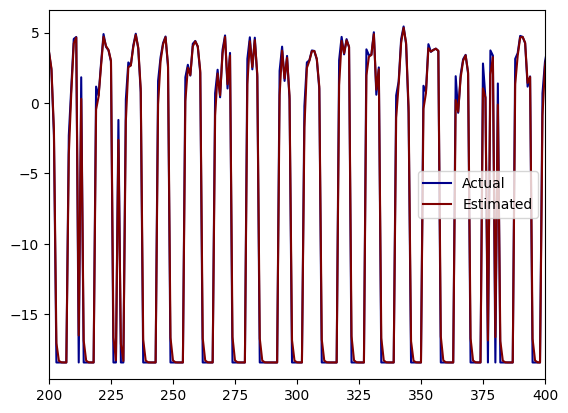

In [179]:
# Using log transformed data perform kalman gain to get the AR(1) coefficient
N = len(y)
a1 = 10   # Value of A1 parameter
# A = [[a1, 0, 0], [0, a1, 0],[0,0,a1]]
A = np.eye(3) 
Re = 1000 * np.eye(3)   #   How fast changes of estimates are reflected. Since y_t = x_t + x_t-1 + x_t-2 exactly, we have to use big values of Re to see this.
Rw = 100    # How noisy the estimate will be

Rxx1 = 10 * np.eye(3)    # How confident we are with initial states
xtt1 = np.array([y[0]/3]*3)    # Set initial states as the first value of rain/3
# xtt1 = np.array([0]*3)    # Set initial states as 0

Xsave = np.zeros((3, N))
ehat = np.zeros(N)
yhat = np.zeros(N)
y1 = copy.deepcopy(y)

for t in range(1, N):
    # print(f'xtt1: {xtt1}')
    Ct = np.array([1,1/a1,1/a1**2]).reshape(1, -1)
    # print(f'Ct: {Ct}')
    Ryy = np.dot(np.dot(Ct, Rxx1), Ct.T) + Rw
    # print(np.dot(Ct, Rxx1))
    # print(f'Ryy: {Ryy}')
    Kt = np.dot(np.dot(Rxx1, Ct.T), np.linalg.inv(Ryy))
    # print(f'Kt: {Kt}')
    yhat[t] = np.dot(Ct, xtt1).item()
    # print(f'yhat_t: {yhat[t]}')
    
    # if np.isnan(y[t]):
    #     # print('y[t] is nan')
    #     Xsave[:,t] = xtt1
    #     Rxx = Rxx1
    #     y1[t] = yhat[t]
    # else:
    
    ehat[t] = y[t] - yhat[t]
    # print(np.dot(Kt, ehat[t]))
    Xsave[:,t] = xtt1 + np.dot(Kt, ehat[t]).T
    Rxx = Rxx1 - np.dot(np.dot(Kt, Ryy), Kt.T)
    
    xtt1 = np.dot(A, Xsave[:,t])
    # print(f'xtt: {Xsave[:,t]}')
    Rxx1 = np.dot(np.dot(A, Rxx), A.T) + Re
    # print(f'Rxx: {Rxx}')
    # print(f'Rxx1: {Rxx1}')
    # Xsave[:, t] = xtt.flatten()
    
# Plot the estimated ar coeffecient
# plt.plot(Xsave[0], color='darkblue', label='Estimated coefficient')
# plt.axhline(Xsave[0][-1], color='maroon', linestyle='dotted', label='Last estimated coefficient')
plt.plot(y[:-1], color='darkblue', label='Actual')
plt.plot(yhat[1:], color='maroon', label='Estimated')
plt.xlim(200, 400)
plt.legend()
print(sum(np.square(np.subtract(y[:-1],yhat[1:]))))
plt.show()

Next thing to do will be to optimize a by plotting various values of A and caluclating sum squared error

(110.0, 140.0)

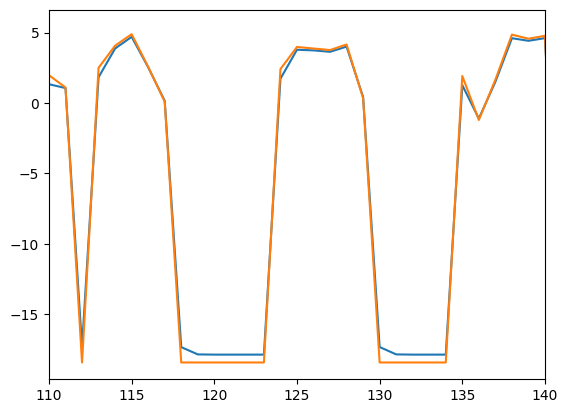

In [132]:
test = [Xsave[0][i] + Xsave[1][i] + Xsave[2][i] for i in range(len(Xsave[0]))]
plt.plot(test)
plt.plot(y)
plt.xlim(110, 140)

In [89]:
y

array([-1.84206807e+01, -1.84206807e+01, -1.84206807e+01, -1.84206807e+01,
        2.80336038e+00,  3.69137633e+00,  4.52178858e+00,  3.84588320e+00,
        4.58394655e+00, -1.84206807e+01, -1.84206807e+01, -1.84206807e+01,
       -1.84206807e+01, -1.84206807e+01, -1.84206807e+01, -1.84206807e+01,
       -1.84206807e+01,  3.08190997e+00,  4.70682384e+00,  4.76388188e+00,
        2.82137889e+00, -1.84206807e+01, -1.84206807e+01, -1.84206807e+01,
       -1.84206807e+01, -1.84206807e+01, -1.84206807e+01, -1.84206807e+01,
       -1.20397277e+00,  1.90210753e+00,  4.64918707e+00,  4.48525989e+00,
        4.15418456e+00,  2.10413416e+00,  2.58021683e+00, -1.84206807e+01,
       -1.84206807e+01, -1.84206807e+01, -1.84206807e+01,  2.83321334e+00,
        3.64021428e+00,  2.10413416e+00,  3.40119738e+00,  4.52178858e+00,
        2.54160199e+00, -1.84206807e+01,  2.20827441e+00, -1.84206807e+01,
       -1.84206807e+01, -1.84206807e+01, -1.84206807e+01,  2.76631911e+00,
       -1.84206807e+01,  

In [124]:
len(test)

480

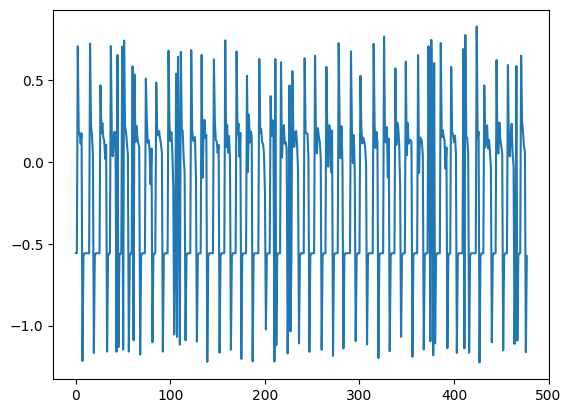

In [133]:
plt.plot(np.array(y[2:]) - np.array(test[2:]))
# plt.xlim(110,140)

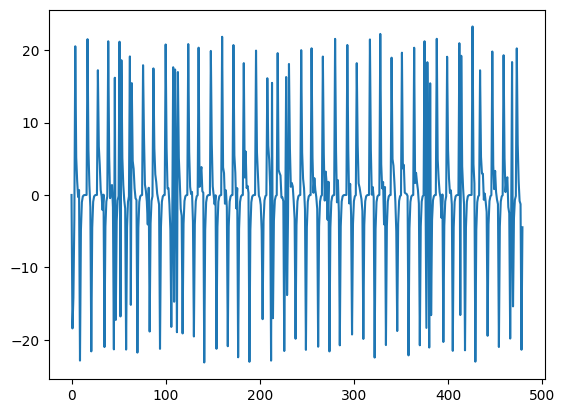

In [94]:
plt.plot(ehat)

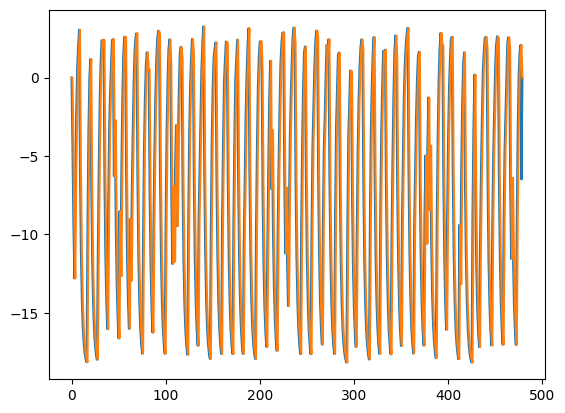

In [71]:
plt.plot(test)
plt.plot(yhat)

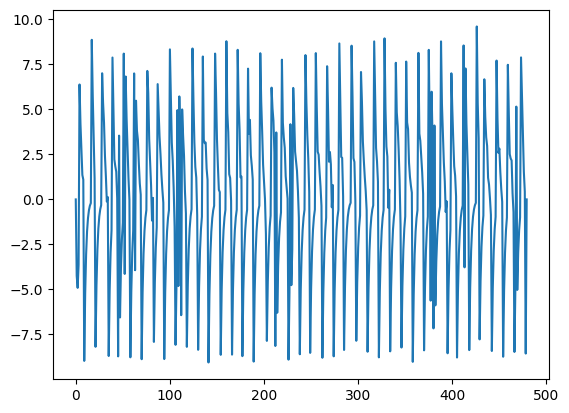

In [75]:
plt.plot(test-yhat)

In [125]:
rainrainrain = []
for i in range(len(Xsave[0])):
    rainrainrain += [Xsave[0][i], Xsave[1][i], Xsave[2][i]]

(400.0, 500.0)

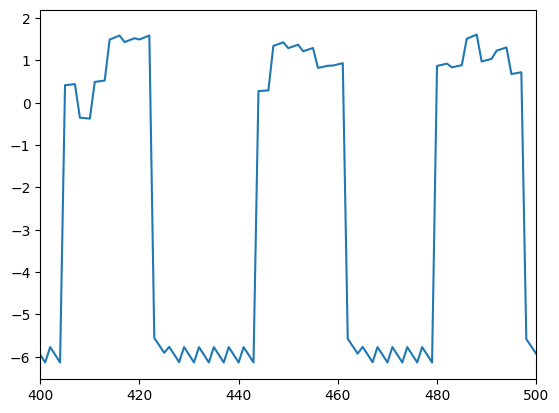

In [126]:
plt.plot(rainrainrain)
plt.xlim(400,500)

In [ ]:
rainrainr

In [128]:
y[:6]

array([-18.42068074, -18.42068074, -18.42068074, -18.42068074,
         2.80336038,   3.69137633])

In [127]:
rainrainrain

[-1.3963119607712393,
 -1.4394968667744736,
 -1.4840173884272927,
 -5.6383200320729046,
 -5.8127010639926855,
 -5.992475323703801,
 -5.766308481826774,
 -5.944647919409046,
 -6.128503009700049,
 -5.7700846598209505,
 -5.948540886413352,
 -6.132516377745725,
 0.6819949224289852,
 0.7030875488958594,
 0.7248325246349108,
 1.1423139706701242,
 1.1776432687320852,
 1.2140652254969992,
 1.408343529937386,
 1.4519005463272008,
 1.4968046869352627,
 1.210714464788331,
 1.2481592420498244,
 1.2867621052060085,
 1.4292578471977488,
 1.4734616981420077,
 1.5190326784969193,
 -5.557790472558108,
 -5.729680899544449,
 -5.906887525303545,
 -5.76393265464584,
 -5.942198613036956,
 -6.12597795158448,
 -5.77001456467296,
 -5.948468623374192,
 -6.132441879767199,
 -5.770194002133082,
 -5.948653610446484,
 -6.132632588089148,
 -5.770199296161102,
 -5.948659068207329,
 -6.132638214646721,
 -5.770199452353307,
 -5.948659229230221,
 -6.132638380649702,
 -5.770199456961519,
 -5.948659233980955,
 -6.13263838

In [ ]:
# Using log transformed data perform kalman gain to get the AR(1) coefficient
N = len(y)
A = np.array([1])
Re = [1e-6]
Rw = 1.25

Rxx1 = [1]
xtt1 = np.array([0])

Xsave = np.zeros((1, N))
ehat = np.zeros(N)
yhat = np.zeros(N)
yt1 = np.zeros(N)
yt2 = np.zeros(N)
y1 = copy.deepcopy(y)

for t in range(1, N):
    Ct = np.array([y1[t-1]])
    # print(Ct)
    Ryy = np.dot(np.dot(Ct, Rxx1), Ct.T) + Rw
    Kt = np.dot(np.dot(Rxx1, Ct.T), [1/Ryy[0]])
    yhat[t] = np.dot(Ct, xtt1).item()
    
    if np.isnan(y[t]):
        xtt = xtt1
        Rxx = Rxx1
        y1[t] = yhat[t]
    else:
        ehat[t] = y[t] - yhat[t]
        xtt = xtt1 + np.dot(Kt, ehat[t])
        Rxx = Rxx1 - np.dot(np.dot(Kt, Ryy), Kt.T)

    xtt1 = np.dot(A, xtt)
    Rxx1 = np.dot(np.dot(A, Rxx), A.T) + Re
    # print(xtt)
    Xsave[:, t] = xtt.flatten()
    
# Plot the estimated ar coeffecient
plt.plot(Xsave[0], color='darkblue', label='Estimated coefficient')
plt.axhline(Xsave[0][-1], color='maroon', linestyle='dotted', label='Last estimated coefficient')
plt.legend()
plt.show()

In [ ]:
# Using log transformed data perform kalman gain to get the AR(1) coefficient
# y = y[:15]
y = rain_df['rain_org'].values
# y = ytest
N = len(y)
a1 = 1
A = a1 * np.eye(3)
Re = [1e-6]
Rw = 1

Rxx1 = [1]
xtt1 = np.array([0])

Xsave = np.zeros((3, N))
ehat = np.zeros(N)
yhat = np.zeros(N)
# yt1 = np.zeros(N)
# yt2 = np.zeros(N)
y1 = copy.deepcopy(y)

for t in range(2, N-1):
    xtt1 = np.dot(A, Xsave[:,t-1])
    # print(f'xtt1: {xtt1}')
    Ct = np.array([1,1,1])
    # print(f'Ct: {Ct}')
    Ryy = np.dot(np.dot(Ct, Rxx1), Ct.T) + Rw
    # print(np.dot(Ct, Rxx1))
    # print(f'Ryy: {Ryy}')
    Kt = np.dot(np.dot(Rxx1, Ct.T), [1/Ryy[0]])
    # print(f'Kt: {Kt}')
    yhat[t] = np.dot(Ct, xtt1).item()
    # print(f'yhat_t: {yhat[t]}')
    
    if np.isnan(y[t]):
        # print('y[t] is nan')
        Xsave[:,t] = xtt1
        Rxx = Rxx1
        y1[t] = yhat[t]
    else:
        ehat[t] = y[t] - yhat[t]
        Xsave[:,t] = xtt1 + np.dot(Kt, ehat[t])
        Rxx = Rxx1 - np.dot(np.dot(Kt, Ryy), Kt.T)

    # print(f'xtt: {Xsave[:,t]}')
    Rxx1 = np.dot(np.dot(A, Rxx), A.T) + Re
    # print(f'Rxx: {Rxx}')
    # print(f'Rxx1: {Rxx1}')
    # Xsave[:, t] = xtt.flatten()
    
# Plot the estimated ar coeffecient
# plt.plot(Xsave[0], color='darkblue', label='Estimated coefficient')
# plt.axhline(Xsave[0][-1], color='maroon', linestyle='dotted', label='Last estimated coefficient')
plt.plot(y, color='darkblue', label='Actual')
plt.plot(yhat, color='maroon', label='Estimated')
# plt.xlim(200, 400)
plt.legend()
plt.show()